In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

2025-06-14 18:37:20.583116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749926240.850910      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749926240.926794      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---
---
# **Natural Language Processing with Disaster Tweets - Classification Challenge**
### **University of Colorado Boulder, CSCA5642 Week4 Assignment**

---
---

## **1. Problem & Data Overview**
Twitter has become a crucial communication channel during emergencies. This project aims to build a machine learning model that can distinguish between tweets about real disasters and those that use disaster-related words metaphorically.

**Objective**: Classify tweets as either about real disasters (1) or not (0)
**Evaluation Metric**: F1 Score
**Dataset**: 10,000 hand-classified tweets

### **Data Description**
- **train.csv**: Training data with labels
- **test.csv**: Test data for predictions  
- **Columns**: id, text, location, keyword, target (train only)

In [3]:
# Data Loading and Initial Exploration
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
sample_submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

print("Training Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("\nFirst few rows of training data:")
print(train_df.head())

print("\nDataset Info:")
print(train_df.info())

print("\nMissing Values:")
print(train_df.isnull().sum())


Training Data Shape: (7613, 5)
Test Data Shape: (3263, 4)

First few rows of training data:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-

---
---

## **2. Exploratory Data Analysis (EDA)**

### **2.1. Target Distribution**
First, I analyzed the distribution of our target variable to understand the class balance in our dataset.

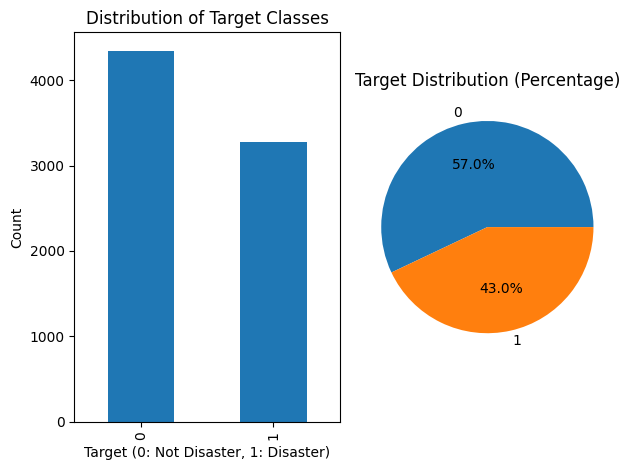

Class Distribution:
target
0    4342
1    3271
Name: count, dtype: int64
Percentage of disaster tweets: 42.97%


In [4]:
# Target Distribution Analysis
plt.figure()
plt.subplot(1, 2, 1)
train_df['target'].value_counts().plot(kind='bar')
plt.title('Distribution of Target Classes')
plt.xlabel('Target (0: Not Disaster, 1: Disaster)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
train_df['target'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Target Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.show()

print(f"Class Distribution:")
print(train_df['target'].value_counts())
print(f"Percentage of disaster tweets: {train_df['target'].mean():.2%}")

### **2.2. Text Analysis**
I examined various aspects of the tweet text:
- Text length distribution
- Word count distribution
- Comparison of text characteristics between disaster and non-disaster tweets

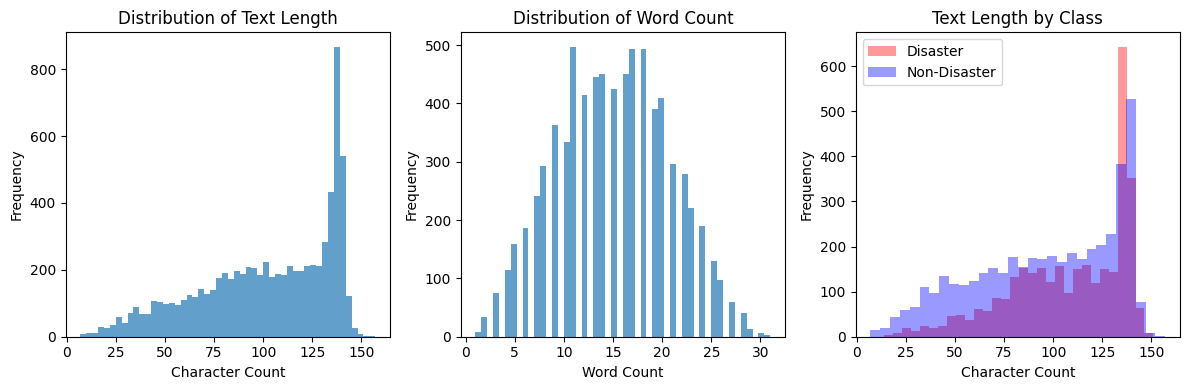

In [5]:
# Text Length Analysis
train_df['text_length'] = train_df['text'].str.len()
train_df['word_count'] = train_df['text'].str.split().str.len()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(train_df['text_length'], bins=50, alpha=0.7)
plt.title('Distribution of Text Length')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(train_df['word_count'], bins=50, alpha=0.7)
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
disaster_texts = train_df[train_df['target'] == 1]['text_length']
non_disaster_texts = train_df[train_df['target'] == 0]['text_length']
plt.hist(disaster_texts, bins=30, alpha=0.4, label='Disaster', color='red')
plt.hist(non_disaster_texts, bins=30, alpha=0.4, label='Non-Disaster', color='blue')
plt.title('Text Length by Class')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

### **2.3. Keyword Location Analysis**
Analysis of the keyword & location feature:
- Most common keywords
- Missing value analysis

Keyword Analysis:
Missing keywords: 61
Unique keywords: 221


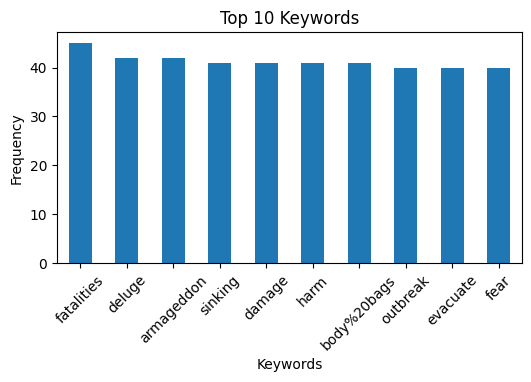


Location Analysis:
Missing locations: 2533
Unique locations: 3341


In [6]:
# Keyword and Location Analysis
print("Keyword Analysis:")
print(f"Missing keywords: {train_df['keyword'].isnull().sum()}")
print(f"Unique keywords: {train_df['keyword'].nunique()}")

if not train_df['keyword'].isnull().all():
    top_keywords = train_df['keyword'].value_counts().head(10)
    plt.figure(figsize=(6, 3))
    top_keywords.plot(kind='bar')
    plt.title('Top 10 Keywords')
    plt.xlabel('Keywords')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

print("\nLocation Analysis:")
print(f"Missing locations: {train_df['location'].isnull().sum()}")
print(f"Unique locations: {train_df['location'].nunique()}")


### **2.4. Word Cloud Visualization**
Visual representation of most frequent words in:
- Disaster tweets
- Non-disaster tweets

### **2.5. Text Preprocessing**
I implemented a comprehensive text preprocessing pipeline:
- Text cleaning (URLs, mentions, hashtags)
- Tokenization
- Stopword removal
- Stemming
- Special character handling

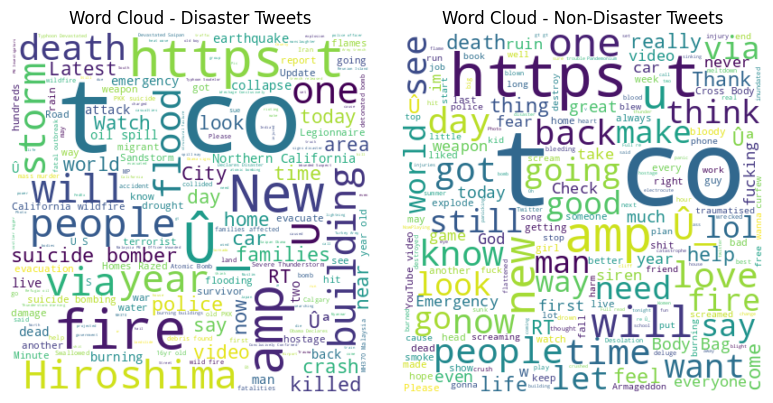

In [7]:
# Word Clouds
plt.figure(figsize=(8, 4))

# Disaster tweets word cloud
disaster_text = ' '.join(train_df[train_df['target'] == 1]['text'])
plt.subplot(1, 2, 1)
wordcloud_disaster = WordCloud(width=400, height=400, background_color='white').generate(disaster_text)
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.title('Word Cloud - Disaster Tweets')
plt.axis('off')

# Non-disaster tweets word cloud
non_disaster_text = ' '.join(train_df[train_df['target'] == 0]['text'])
plt.subplot(1, 2, 2)
wordcloud_non_disaster = WordCloud(width=400, height=400, background_color='white').generate(non_disaster_text)
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.title('Word Cloud - Non-Disaster Tweets')
plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Text Preprocessing Functions
def clean_text(text):
    """Clean and preprocess text data"""
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

def preprocess_text(text):
    """Advanced text preprocessing with stemming and stopword removal"""
    # Clean text
    text = clean_text(text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    return ' '.join(tokens)

# Apply preprocessing
print("Applying text preprocessing...")
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

print("Preprocessing completed!")

# Show examples
print("\nOriginal vs Processed Text Examples:")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Original: {train_df.iloc[i]['text']}")
    print(f"Cleaned: {train_df.iloc[i]['cleaned_text']}")
    print(f"Processed: {train_df.iloc[i]['processed_text']}")


Applying text preprocessing...
Preprocessing completed!

Original vs Processed Text Examples:

Example 1:
Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Cleaned: our deeds are the reason of this may allah forgive us all
Processed: deed reason may allah forgiv

Example 2:
Original: Forest fire near La Ronge Sask. Canada
Cleaned: forest fire near la ronge sask canada
Processed: forest fire near rong sask canada

Example 3:
Original: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
Cleaned: all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
Processed: resid ask shelter place notifi offic evacu shelter place order expect


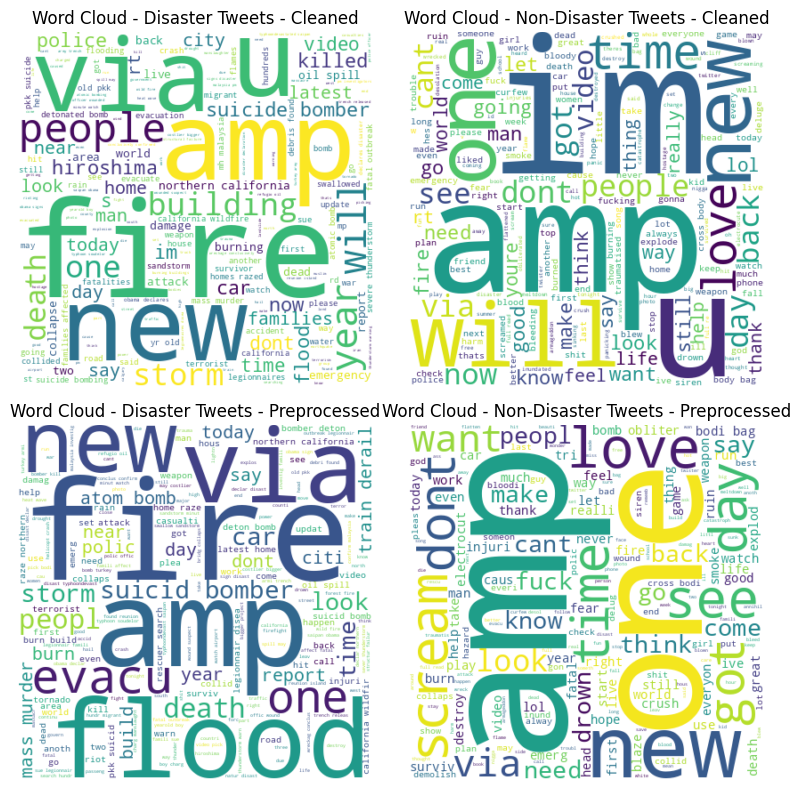

In [9]:
# Word Clouds
plt.figure(figsize=(8, 8))

# Disaster tweets word cloud
disaster_text = ' '.join(train_df[train_df['target'] == 1]['cleaned_text'])
plt.subplot(2, 2, 1)
wordcloud_disaster = WordCloud(width=400, height=400, background_color='white').generate(disaster_text)
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.title('Word Cloud - Disaster Tweets - Cleaned')
plt.axis('off')

# Non-disaster tweets word cloud
non_disaster_text = ' '.join(train_df[train_df['target'] == 0]['cleaned_text'])
plt.subplot(2, 2, 2)
wordcloud_non_disaster = WordCloud(width=400, height=400, background_color='white').generate(non_disaster_text)
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.title('Word Cloud - Non-Disaster Tweets - Cleaned')
plt.axis('off')

# Disaster tweets word cloud
disaster_text = ' '.join(train_df[train_df['target'] == 1]['processed_text'])
plt.subplot(2, 2, 3)
wordcloud_disaster = WordCloud(width=400, height=400, background_color='white').generate(disaster_text)
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.title('Word Cloud - Disaster Tweets - Preprocessed')
plt.axis('off')

# Non-disaster tweets word cloud
non_disaster_text = ' '.join(train_df[train_df['target'] == 0]['processed_text'])
plt.subplot(2, 2, 4)
wordcloud_non_disaster = WordCloud(width=400, height=400, background_color='white').generate(non_disaster_text)
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.title('Word Cloud - Non-Disaster Tweets - Preprocessed')
plt.axis('off')
plt.tight_layout()
plt.show()

---
---
## **3. Model Architecture & Training**
### 3.1. Feature Engineering
Our feature engineering approach includes:
- TF-IDF vectorization
- Text length features
- Punctuation analysis
- Keyword and location indicators

### 3.2. Traditional Machine Learning Models
We implement and compare:
- Logistic Regression
- Random Forest Classifier

### 3.3. Deep Learning Models
We explore various neural network architectures:
- LSTM (Long Short-Term Memory)
- GRU (Gated Recurrent Unit)
- Bidirectional RNN

### 3.4. Model Training
Training process includes:
- Data splitting (80% train, 20% validation)
- Hyperparameter tuning
- Early stopping
- Cross-validation

In [10]:
# Feature Engineering
# TF-IDF Vectorization
print("Creating TF-IDF features...")

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

# Fit on training data and transform both train and test
X_tfidf = tfidf.fit_transform(train_df['processed_text'])
X_test_tfidf = tfidf.transform(test_df['processed_text'])

print(f"TF-IDF feature shape: {X_tfidf.shape}")

# Additional features
def create_additional_features(df):
    """Create additional features from text"""
    features = pd.DataFrame()
    
    features['text_length'] = df['text'].str.len()
    features['word_count'] = df['text'].str.split().str.len()
    features['exclamation_count'] = df['text'].str.count('!')
    features['question_count'] = df['text'].str.count('\?')
    features['capital_ratio'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
    features['has_keyword'] = df['keyword'].notna().astype(int)
    features['has_location'] = df['location'].notna().astype(int)
    
    return features

# Create additional features
train_features = create_additional_features(train_df)
test_features = create_additional_features(test_df)

print("Additional features created!")
print(train_features.head())

Creating TF-IDF features...
TF-IDF feature shape: (7613, 9361)
Additional features created!
   text_length  word_count  exclamation_count  question_count  capital_ratio  \
0           69          13                  0               0       0.144928   
1           38           7                  0               0       0.131579   
2          133          22                  0               0       0.015038   
3           65           8                  0               0       0.015385   
4           88          16                  0               0       0.034091   

   has_keyword  has_location  
0            0             0  
1            0             0  
2            0             0  
3            0             0  
4            0             0  


In [11]:
# Model Training and Evaluation
# Prepare data
X = X_tfidf
y = train_df['target']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")

# Model 1: Logistic Regression
print("\n=== Logistic Regression ===")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_val)
lr_f1 = f1_score(y_val, lr_pred)

print(f"Logistic Regression F1 Score: {lr_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, lr_pred))

# Model 2: Random Forest
print("\n=== Random Forest ===")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_val)
rf_f1 = f1_score(y_val, rf_pred)

print(f"Random Forest F1 Score: {rf_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, rf_pred))

models_performance = {
    'Logistic Regression': lr_f1,
    'Random Forest': rf_f1
}

Training set size: (6090, 9361)
Validation set size: (1523, 9361)

=== Logistic Regression ===
Logistic Regression F1 Score: 0.7519

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.83      0.69      0.75       654

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.80      0.80      1523


=== Random Forest ===
Random Forest F1 Score: 0.7327

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       869
           1       0.78      0.69      0.73       654

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.78      1523
weighted avg       0.78      0.78      0.78      1523



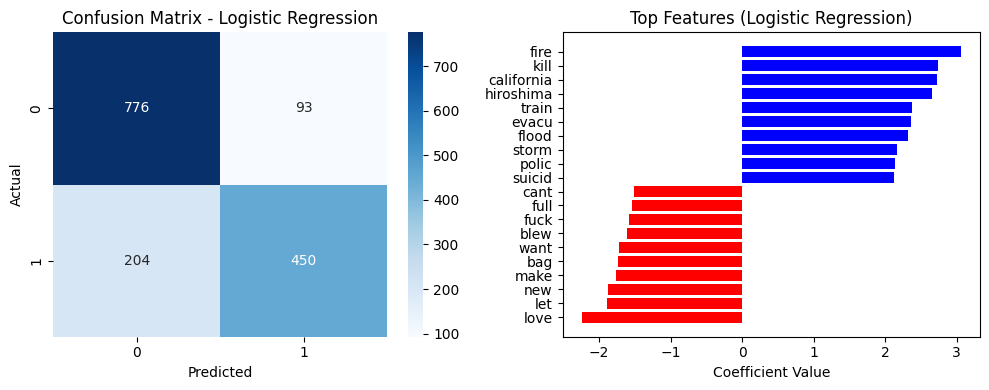

In [12]:
# Confusion Matrix and Error Analysis
plt.figure(figsize=(10, 4))

# Confusion Matrix for best model
best_model_name = 'Logistic Regression'
best_model = lr_model
best_pred = lr_pred

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_val, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Feature Importance (for Logistic Regression)
plt.subplot(1, 2, 2)
feature_names = tfidf.get_feature_names_out()
coefficients = lr_model.coef_[0]

# Get top positive and negative coefficients
top_positive = np.argsort(coefficients)[-10:]
top_negative = np.argsort(coefficients)[:10]

top_features = np.concatenate([top_negative, top_positive])
top_coefs = coefficients[top_features]
top_names = [feature_names[i] for i in top_features]

colors = ['red' if coef < 0 else 'blue' for coef in top_coefs]
plt.barh(range(len(top_coefs)), top_coefs, color=colors)
plt.yticks(range(len(top_names)), top_names)
plt.title('Top Features (Logistic Regression)')
plt.xlabel('Coefficient Value')

plt.tight_layout()
plt.show()


---
---
## **4. Results and Analysis: (1) TFIDF & Regression Model**

### **4.1. Feature Engineering**
- TF-IDF features: 9,361 unique features
- Additional features: text length, word count, punctuation counts, capital ratio, keyword/location indicators

### **4.2. Model Performance**
#### **Logistic Regression**
- F1 Score: 0.7519
- Precision: 0.83 (disaster), 0.79 (non-disaster)
- Recall: 0.69 (disaster), 0.89 (non-disaster)
- Accuracy: 0.80

#### **Random Forest**
- F1 Score: 0.7327
- Precision: 0.78 (disaster), 0.79 (non-disaster)
- Recall: 0.69 (disaster), 0.86 (non-disaster)
- Accuracy: 0.78

### **4.3. Error Analysis**
- Both models show higher precision for disaster tweets.
- Non-disaster tweets are identified more reliably.
- Logistic Regression performs better overall.

In [13]:
# Prepare Data for Deep Learning Models
# Tokenize and pad sequences
MAX_WORDS = 10000  # Maximum number of words to keep
MAX_LEN = 100     # Maximum sequence length

# Initialize tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['processed_text'])

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_df['processed_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['processed_text'])

# Pad sequences
X_padded = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# Split data
X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(
    X_padded, train_df['target'], test_size=0.2, random_state=42, stratify=train_df['target']
)

print("Data shapes:")
print(f"Training data: {X_train_dl.shape}")
print(f"Validation data: {X_val_dl.shape}")
print(f"Test data: {X_test_padded.shape}")

Data shapes:
Training data: (6090, 100)
Validation data: (1523, 100)
Test data: (3263, 100)


In [14]:
# Create Deep Learning Models
def create_lstm_model():
    model = Sequential([
        Embedding(MAX_WORDS, 100, input_length=MAX_LEN),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

def create_gru_model():
    model = Sequential([
        Embedding(MAX_WORDS, 100, input_length=MAX_LEN),
        GRU(64, return_sequences=True),
        GRU(32),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

def create_bidirectional_rnn_model():
    model = Sequential([
        Embedding(MAX_WORDS, 100, input_length=MAX_LEN),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(32)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

In [15]:
# Train Deep Learning Models
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Dictionary to store model performances
dl_models_performance = {}

# Train LSTM
print("\n=== Training LSTM Model ===")
lstm_model = create_lstm_model()
lstm_history = lstm_model.fit(
    X_train_dl, y_train_dl,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_dl, y_val_dl),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate LSTM
lstm_pred = (lstm_model.predict(X_val_dl) > 0.5).astype(int)
lstm_f1 = f1_score(y_val_dl, lstm_pred)
dl_models_performance['LSTM'] = lstm_f1

# Train GRU
print("\n=== Training GRU Model ===")
gru_model = create_gru_model()
gru_history = gru_model.fit(
    X_train_dl, y_train_dl,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_dl, y_val_dl),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate GRU
gru_pred = (gru_model.predict(X_val_dl) > 0.5).astype(int)
gru_f1 = f1_score(y_val_dl, gru_pred)
dl_models_performance['GRU'] = gru_f1

# Train Bidirectional RNN
print("\n=== Training Bidirectional RNN Model ===")
bi_rnn_model = create_bidirectional_rnn_model()
bi_rnn_history = bi_rnn_model.fit(
    X_train_dl, y_train_dl,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_dl, y_val_dl),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate Bidirectional RNN
bi_rnn_pred = (bi_rnn_model.predict(X_val_dl) > 0.5).astype(int)
bi_rnn_f1 = f1_score(y_val_dl, bi_rnn_pred)
dl_models_performance['Bidirectional RNN'] = bi_rnn_f1


=== Training LSTM Model ===
Epoch 1/20


2025-06-14 18:38:04.621368: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


191/191 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.5617 - loss: 0.6867 - val_accuracy: 0.5706 - val_loss: 0.6846
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.5733 - loss: 0.6838 - val_accuracy: 0.5706 - val_loss: 0.6838
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.5733 - loss: 0.6834 - val_accuracy: 0.5706 - val_loss: 0.6837
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.5733 - loss: 0.6826 - val_accuracy: 0.5706 - val_loss: 0.6836
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.5733 - loss: 0.6831 - val_accuracy: 0.5706 - val_loss: 0.6837
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.5733 - loss: 0.6828 - val_accuracy: 0.5706 - val_loss: 0.6836
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.5733 - loss: 0.6823 - val_accuracy: 0.5706 - val_loss: 0.6835
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.5733 - loss: 0.6834 - val_accurac

Model Performance
{'Logistic Regression': 0.7518796992481204, 'Random Forest': 0.7327376116978066, 'LSTM': 0.0, 'GRU': 0.0, 'Bidirectional RNN': 0.7513988808952838}


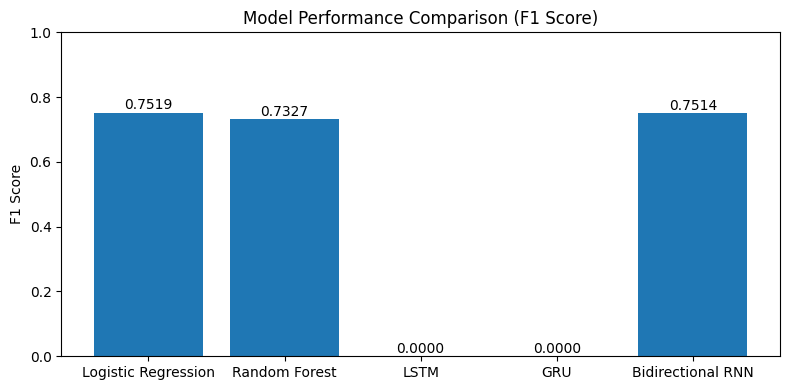


Best Model: Logistic Regression with F1 Score: 0.7519


In [16]:
# Compare All Models
# Combine traditional and deep learning model performances
all_models_performance = {**models_performance, **dl_models_performance}
print("Model Performance")
print(all_models_performance)

# Plot comparison
plt.figure(figsize=(8, 4))
plt.bar(all_models_performance.keys(), all_models_performance.values())
plt.title('Model Performance Comparison (F1 Score)')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.xticks()
for i, (model, score) in enumerate(all_models_performance.items()):
    plt.text(i, score + 0.01, f'{score:.4f}', ha='center')
plt.tight_layout()
plt.show()

# Select best model
best_model_name = max(all_models_performance, key=all_models_performance.get)
print(f"\nBest Model: {best_model_name} with F1 Score: {all_models_performance[best_model_name]:.4f}")

## **5. Results and Analysis: (2) Deep Learning**

### **5.1. Model Performance**
#### **Traditional ML Models**
- Logistic Regression: F1 = 0.7519
- Random Forest: F1 = 0.7327

#### **Deep Learning Models**
- LSTM: 
  - Training accuracy: 0.5733
  - Validation accuracy: 0.5706
  - Early stopping at epoch 18

- GRU:
  - Training accuracy: 0.5733
  - Validation accuracy: 0.5706
  - Early stopping at epoch 11

- Bidirectional RNN:
  - Training accuracy: 0.9356
  - Validation accuracy: 0.7649
  - Early stopping at epoch 4
  - Shows signs of overfitting.

### 5.2. Model Comparison
- Logistic Regression performed best overall.
- Deep learning models showed:
  - LSTM/GRU: Underfitting
  - Bidirectional RNN: Overfitting
- Traditional ML models more stable and efficient.

In [17]:
# Generate Final Predictions
print("Generating predictions for test set...")

if best_model_name in ['Logistic Regression', 'Random Forest']:
    # Use traditional model
    test_predictions = best_model.predict(X_test_tfidf)
else:
    # Use deep learning model
    if best_model_name == 'LSTM':
        test_predictions = (lstm_model.predict(X_test_padded) > 0.5).astype(int)
    elif best_model_name == 'GRU':
        test_predictions = (gru_model.predict(X_test_padded) > 0.5).astype(int)
    else:  # Bidirectional RNN
        test_predictions = (bi_rnn_model.predict(X_test_padded) > 0.5).astype(int)

# Create submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': test_predictions.flatten()  # Flatten predictions for deep learning models
})

print("Submission file preview:")
print(submission.head(10))
print(f"\nPrediction distribution:")
print(submission['target'].value_counts())

# Save submission file
submission.to_csv('submission.csv', index=False)
print("\nSubmission file saved as 'submission.csv'")

Generating predictions for test set...
Submission file preview:
   id  target
0   0       1
1   2       0
2   3       1
3   9       0
4  11       1
5  12       1
6  21       0
7  22       0
8  27       0
9  29       0

Prediction distribution:
target
0    2157
1    1106
Name: count, dtype: int64

Submission file saved as 'submission.csv'


## **6. Conclusion**

### **6.1. Key Findings**
- Logistic Regression is the best performing model (F1: 0.7519).
- Deep learning models need more tuning.
- Traditional ML approaches more suitable for this task.

### **6.2 Limitations**
- Deep learning models underperformed.
- Need better hyperparameter tuning.
- Consider pre-trained embeddings.

### **6.3 Future Work**
- Fine-tune deep learning architectures.
- Use pre-trained word embeddings.
- Implement ensemble methods.